### Monitoring

https://docs.google.com/forms/d/e/1FAIpQLSdp5m6U0yyQMQgGNgYeM3bnLMY65sNOelxp8Ur0lOg4rVLmyw/viewform?usp=sf_link

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess, cv2, json, os, sys, shutil, pyk4a, time
import numpy as np, matplotlib.pyplot as plt
from kinectacq.acquisition import start_recording
from kinectacq.paths import DATA_DIR, ensure_dir
from pathlib2 import Path

In [3]:
# WHERE TO SAVE DATA
DATA_DIR = Path('/mnt/chronic/TimS/azure')
subject = '22_3_3_chr'

### Get camera information

In [4]:
!k4arecorder --list

Index:0	Serial:000237292012	Color:1.6.108	Depth:1.6.79


### Set up devices
- each k4a device needs to be configured
- multi-camera rigs need to set up the WiredSyncMode
    - Master = WiredSyncMode.MASTER
    - Subordinate = WiredSyncMode.SUBORDINATE
    - subordinate_delay_off_master_usec=640 (master samples every 900usec)
- [Kinect SDK](https://microsoft.github.io/Azure-Kinect-Sensor-SDK/master/structk4a__device__configuration__t_a8208974f05d89fc1362c6a0900bdef4d.html#a8208974f05d89fc1362c6a0900bdef4d)

In [5]:
from pyk4a import (
    PyK4A,
    Config,
    ColorResolution,
    DepthMode,
    WiredSyncMode,
)

In [6]:
devices = {
    "master": {
        "id": 0,
        "pyk4a_config": {
            "color_resolution": ColorResolution.RES_720P,
            "depth_mode": DepthMode.NFOV_UNBINNED,
            #"synchronized_images_only": False,
            #"wired_sync_mode": WiredSyncMode.MASTER,
        },
        "process_kwargs": {
            "display_frames": True,
            "display_time": True,
            "save_color": True,
        },
    }
}

### Set up processing functions
- Functions for reducing video file sizes to 8 bit. 

In [7]:
_dtype = np.uint16
if _dtype == np.uint8:
    def process_depth(depth):
        return np.clip((depth - 435) * (depth < 690), 0, 255).astype(_dtype)
    def process_ir(ir):
        ir = np.clip(ir + 100, 160, 5500)
        return ((np.log(ir) - 5) * 70).astype(_dtype)
    ir_display_fcn=None
elif _dtype == np.uint16:
    def process_depth(depth):
        depth = depth.astype(_dtype)
        return depth
    def process_ir(ir):
        return ir.astype(_dtype)
    def process_ir_16(ir):
        ir = (np.clip(ir, 0, 8000)/32).astype(np.uint8)
        return ir
    ir_display_fcn = process_ir_16

In [8]:
ir_display_fcn

<function __main__.process_ir_16(ir)>

### Recording parameters

In [9]:
depth_write_frames_kwargs={
        "codec": "ffv1", #"ffv1",
        "crf": 0, # The range of the CRF scale is 0–51, where 0 is lossless (for 8 bit only, for 10 bit use -qp 0), 23 is the default, and 51 is worst quality possible
        "threads": 6, # Set the number of threads to use while encoding.
        "fps": 30,
        "slices": 24, # Number of slices, used in parallelized encoding.
        "slicecrc": 1, # Enabling this option adds CRC information to each slice
        "frame_size": None,
        "get_cmd": False,
    }

In [10]:
ir_write_frames_kwargs={
        "codec": "h264", #"ffv1",
        "crf": 0, # The range of the CRF scale is 0–51, where 0 is lossless (for 8 bit only, for 10 bit use -qp 0), 23 is the default, and 51 is worst quality possible
        "threads": 6, # Set the number of threads to use while encoding.
        "fps": 30,
        "slices": 24, # Number of slices, used in parallelized encoding.
        "slicecrc": 1, # Enabling this option adds CRC information to each slice
        "frame_size": None,
        "get_cmd": False,
    }

In [11]:
color_write_frames_kwargs={
        "codec": "h264", #"h264",
        "crf": 22,
        "threads": 6,
        "fps": 30,
        "slices": 24,
        "slicecrc": 1,
        "frame_size": None,
        "get_cmd": False,
    }

In [13]:
recording_duration_s = 60*60*1

### Run recording

In [14]:
import datetime

In [15]:
import time

In [ ]:
try: 
    while True:
        # create a new timestamp
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        print(timestamp)
        filename_prefix = DATA_DIR / subject / timestamp
        ensure_dir(filename_prefix)

        # start recording
        start_recording(
            filename_prefix,
            recording_duration_s,
            devices=devices,
            depth_function = process_depth,
            ir_function = process_ir,
            ir_dtype = _dtype,
            depth_dtype = _dtype,
            ir_write_frames_kwargs=ir_write_frames_kwargs,
            depth_write_frames_kwargs=depth_write_frames_kwargs,
            color_write_frames_kwargs=color_write_frames_kwargs,
            ir_display_fcn=ir_display_fcn,
        )
        
        # wait until the previous file is finished writing
        for device in devices:
            while True:
                is_writing = np.load(filename_prefix / device / 'is_writing.npy')[0]
                if is_writing == False:
                    break
                time.sleep(1)
        
except KeyboardInterrupt:
    print('KeyboardInterrupt: notebook loop')

2022-03-03_14-50-20


master (frames written):   0%|          | 0/108000 [00:00<?, ?it/s]

Recording (s):   0%|          | 0/3600 [00:00<?, ?it/s]

capture_from_azure initialized: master 
 

### Read and show file

In [267]:
print('\n'.join([i.as_posix() for i in list((filename_prefix/'master').iterdir())]))

/mnt/chronic/TimS/azure/22_3_3_chronic/2022-03-03_14-42-36/master/depth_timestamps.npy
/mnt/chronic/TimS/azure/22_3_3_chronic/2022-03-03_14-42-36/master/system_timestamps.npy
/mnt/chronic/TimS/azure/22_3_3_chronic/2022-03-03_14-42-36/master/is_writing.npy
/mnt/chronic/TimS/azure/22_3_3_chronic/2022-03-03_14-42-36/master/ir.avi
/mnt/chronic/TimS/azure/22_3_3_chronic/2022-03-03_14-42-36/master/depth.avi
/mnt/chronic/TimS/azure/22_3_3_chronic/2022-03-03_14-42-36/master/calibration.json
/mnt/chronic/TimS/azure/22_3_3_chronic/2022-03-03_14-42-36/master/color.avi
/mnt/chronic/TimS/azure/22_3_3_chronic/2022-03-03_14-42-36/master/color_timestamps.npy
/mnt/chronic/TimS/azure/22_3_3_chronic/2022-03-03_14-42-36/master/ir_timestamps.npy


In [268]:
system_timestamps = np.load(filename_prefix / 'master' / 'system_timestamps.npy')

In [269]:
len(system_timestamps)

296

In [270]:
len(system_timestamps) /((np.max(system_timestamps) - np.min(system_timestamps))*1e-9)

30.103614171685983

In [271]:
((np.max(system_timestamps) - np.min(system_timestamps))*1e-9)

9.832706409

In [272]:
depth_timestamps = np.load(filename_prefix / 'master' / 'depth_timestamps.npy')
system_timestamps = np.load(filename_prefix / 'master' / 'system_timestamps.npy')

In [273]:
#plt.plot((system_timestamps[0] - system_timestamps)- depth_timestamps);

In [274]:
from kinectacq.video_io import read_frames

In [275]:
file_loc = filename_prefix / 'master' /  "ir.avi"
frames = read_frames(
    file_loc,
    [0,1,2],
    threads=6,
    fps=30,
    pixel_format="gray16",
    frame_size=(640, 576),
    slices=24,
    slicecrc=1,
    get_cmd=False,
)

In [276]:
file_loc

PosixPath('/mnt/chronic/TimS/azure/22_3_3_chronic/2022-03-03_14-42-36/master/ir.avi')

In [277]:
vidcap = cv2.VideoCapture(file_loc.as_posix())
total_frames = vidcap.get(7)

In [278]:
nbit = 16
total_expected_bits = total_frames * np.product(frames[0].shape) * nbit
total_expected_MB_uncompressed = total_expected_bits * 1.192e-7 
GB_per_hour = os.path.getsize(file_loc) / (recording_duration_s / (60*60)) * 1e-9
print('uncompressed size: {} MB'.format(round(total_expected_MB_uncompressed)))
print('actual_size: {} MB'.format(round(os.path.getsize(file_loc) * 1e-6)))
print('size per hour: {} GB'.format(round(GB_per_hour, 1)))

uncompressed size: 208 MB
actual_size: 14 MB
size per hour: 5.1 GB


(array([  994.,   872., 12600.,  2058.,  1255.,  4568., 29504., 21270.,
         1828.,    51.]),
 array([ 257. , 1079.4, 1901.8, 2724.2, 3546.6, 4369. , 5191.4, 6013.8,
        6836.2, 7658.6, 8481. ]),
 <BarContainer object of 10 artists>)

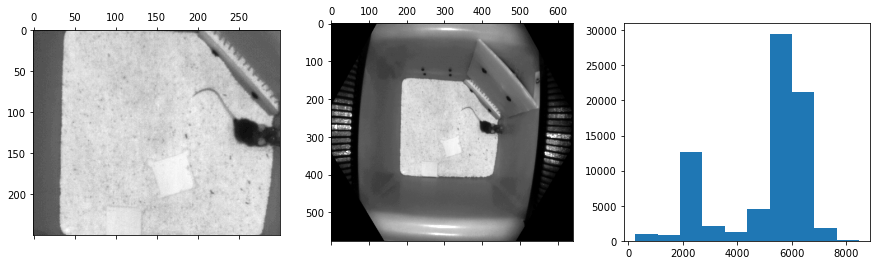

In [279]:
fig, axs = plt.subplots(ncols=3, figsize=(15,4))
frame = frames[0].astype(np.float32)
axs[1].matshow(frame, cmap='Greys_r', vmin = 0, vmax=8000, interpolation=None)

frame = frames[0][150:400, 150:450]
axs[0].matshow(frame, cmap='Greys_r', vmin = 0, vmax=8000, interpolation=None)
axs[2].hist(frame.flatten())

### Depth data

In [280]:
file_loc = filename_prefix / 'master' /  "depth.avi"
frames = read_frames(
    file_loc,
    [0,1,2],
    threads=6,
    fps=30,
    pixel_format="gray16",
    frame_size=(640, 576),
    slices=24,
    slicecrc=1,
    get_cmd=False,
)
vidcap = cv2.VideoCapture(file_loc.as_posix())
total_frames = vidcap.get(7)

In [281]:
nbit = 16
total_expected_bits = total_frames * np.product(frames[0].shape) * nbit
total_expected_MB_uncompressed = total_expected_bits * 1.192e-7 
GB_per_hour = os.path.getsize(file_loc) / (recording_duration_s / (60*60)) * 1e-9
print('uncompressed size: {} MB'.format(round(total_expected_MB_uncompressed)))
print('actual_size: {} MB'.format(round(os.path.getsize(file_loc) * 1e-6)))
print('size per hour: {} GB'.format(round(GB_per_hour, 1)))

uncompressed size: 208 MB
actual_size: 16 MB
size per hour: 5.9 GB


(array([  299.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,   145.,   116.,   384.,
         1705., 15031., 49678.,  7642.]),
 array([  0. ,  32.4,  64.8,  97.2, 129.6, 162. , 194.4, 226.8, 259.2,
        291.6, 324. , 356.4, 388.8, 421.2, 453.6, 486. , 518.4, 550.8,
        583.2, 615.6, 648. ]),
 <BarContainer object of 20 artists>)

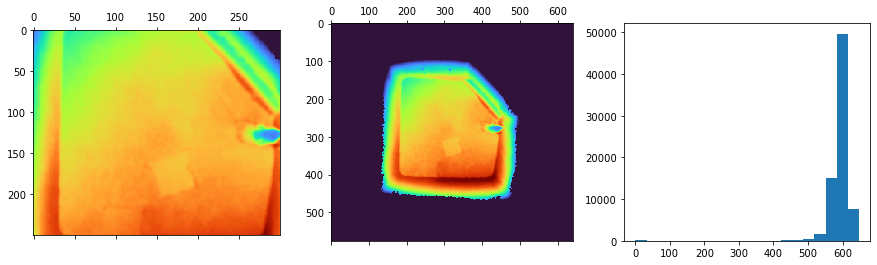

In [282]:
fig, axs = plt.subplots(ncols=3, figsize=(15,4))
frame = frames[0].astype(np.float32)
axs[1].matshow(frame, cmap='turbo', vmin = 500, vmax=650)

frame = frames[0][150:400, 150:450]
axs[0].matshow(frame, cmap='turbo', vmin = 500, vmax=650)
axs[2].hist(frame.flatten(), bins=20)

### color data

In [283]:
file_loc = filename_prefix / 'master' /  "color.avi"
vidcap = cv2.VideoCapture(file_loc.as_posix())
success,image = vidcap.read()
total_frames = vidcap.get(7)
print(total_frames, image.shape)

296.0 (720, 1280, 3)


In [284]:
nbit = 16
total_expected_bits = total_frames * np.product(frames[0].shape) * nbit
total_expected_MB_uncompressed = total_expected_bits * 1.192e-7 
GB_per_hour = os.path.getsize(file_loc) / (recording_duration_s / (60*60)) * 1e-9
print('uncompressed size: {} MB'.format(round(total_expected_MB_uncompressed)))
print('actual_size: {} MB'.format(round(os.path.getsize(file_loc) * 1e-6)))
print('size per hour: {} GB'.format(round(GB_per_hour, 1)))

uncompressed size: 208 MB
actual_size: 14 MB
size per hour: 5.0 GB


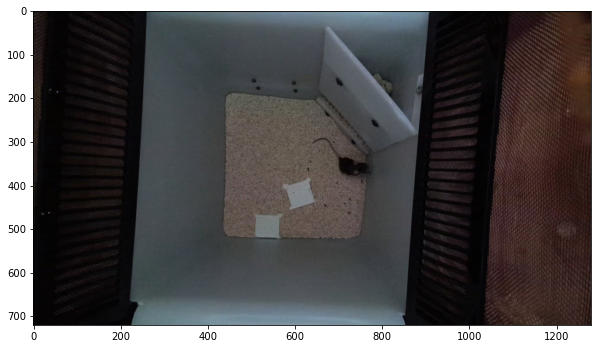

In [285]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(image)

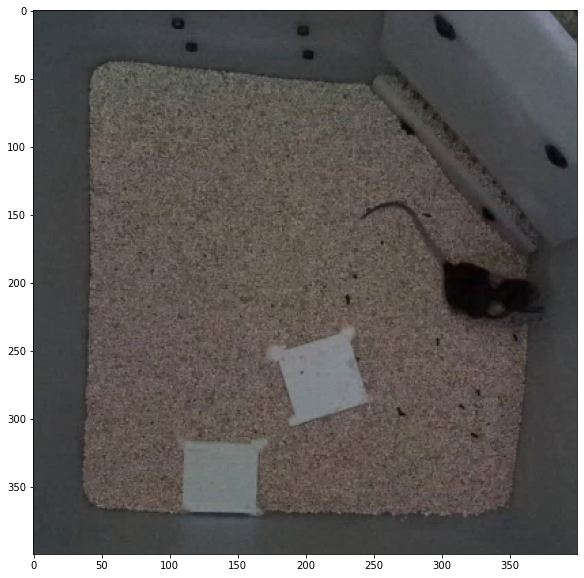

In [286]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(image[150:550, 400:800])